<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/part/RO1_SO2_Identification_Part_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

## Hyperparameters

In [16]:
# Hyperparameters
learning_rate = 1E-4 #@param {type:"integer"}
batch_size = 32 # @param {type:"integer"}
epochs = 1000 # @param {type:"integer"}

# Pre-processing

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import drive
import os
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):

    def __init__(self, samples, labels):
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.labels = torch.tensor([np.array(ys) for ys in labels], dtype=torch.float32)

        # Normalize the features to be between in [0,1]
        self.samples = F.normalize(self.samples, dim = 0)

        # full_batch_size = self.samples.shape[0]  # Get the batch size
        # in_channels = 1  # The number of channels in each item
        # sequence_length = self.samples[0].shape[0]  # Get the sequence length
        # # Reshape the input data
        # self.samples = self.samples.view(full_batch_size, in_channels, sequence_length)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

drive.mount('/content/drive')
print(f"[INFO] ls {os.listdir('/content/drive/My Drive')}")
path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)
# Load the dataset
print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
y = data['m/z'].apply(lambda x:
                          [1,0,0,0,0,0] if 'Fillet' in x
                    else ([0,1,0,0,0,0] if 'Heads' in x
                    else ([0,0,1,0,0,0] if 'Livers' in x
                    else ([0,0,0,1,0,0] if 'Skins' in x
                    else ([0,0,0,0,1,0] if 'Guts' in x
                    else ([0,0,0,0,0,1] if 'Frames' in x
                    else None ))))))  # Labels (0 for Hoki, 1 for Moki)
xs = []
ys = []
for (x,y) in zip(X.to_numpy(),y):
    if y is not None:
       xs.append(x)
       ys.append(y)
X = np.array(xs)
y = np.array(ys)

# Evaluation parameters.
train_split = 0.8
val_split = 0.5 # 1/2 of 20%, validation and test, 10% and 10%, respectively.

# Step 2: Split your dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=(1-train_split), random_state=21998)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split, random_state=21998)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

assert train_dataset.samples.shape[0] == train_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert val_dataset.samples.shape[0] == val_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."
assert test_dataset.samples.shape[0] == test_dataset.labels.shape[0] , "train_dataset samples and labels should have same length."

# Step 4: Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# calculate steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size
# when batch_size greater than dataset size, avoid division by zero.
train_steps = max(1, train_steps)
val_steps = max(1, val_steps)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] ls ['Colab Notebooks', 'University', 'AI', 'profile.jpg', 'personal', 'ass3_example_solutions_marking_guides_2023_V2.docx', 'JAPA101: Handwriting Assignment - Part 2 - Creative Writing and Reflection.gdoc']
[INFO] Reading the dataset.


# CNN

[INFO] Initialize cuda environment
[INFO] Initializing the LeNet model
[INFO] Training the network
[INFO] EPOCH: 1/1000
Train loss: 2.174419, Train accuracy: 0.2083
Val loss: 1.776574, Val accuracy: 0.3333

[INFO] EPOCH: 51/1000
Train loss: 1.403694, Train accuracy: 1.0000
Val loss: 1.836127, Val accuracy: 0.3333

[INFO] EPOCH: 101/1000
Train loss: 1.382382, Train accuracy: 1.0000
Val loss: 2.330138, Val accuracy: 0.3333

[INFO] EPOCH: 151/1000
Train loss: 1.364209, Train accuracy: 1.0000
Val loss: 2.298119, Val accuracy: 0.3333

[INFO] EPOCH: 201/1000
Train loss: 1.368798, Train accuracy: 1.0000
Val loss: 2.215871, Val accuracy: 0.3333

[INFO] EPOCH: 251/1000
Train loss: 1.367852, Train accuracy: 1.0000
Val loss: 2.191697, Val accuracy: 0.3333

[INFO] EPOCH: 301/1000
Train loss: 1.364864, Train accuracy: 1.0000
Val loss: 2.172592, Val accuracy: 0.3333

[INFO] EPOCH: 351/1000
Train loss: 1.364216, Train accuracy: 1.0000
Val loss: 2.136454, Val accuracy: 0.3333

[INFO] EPOCH: 401/1000
T

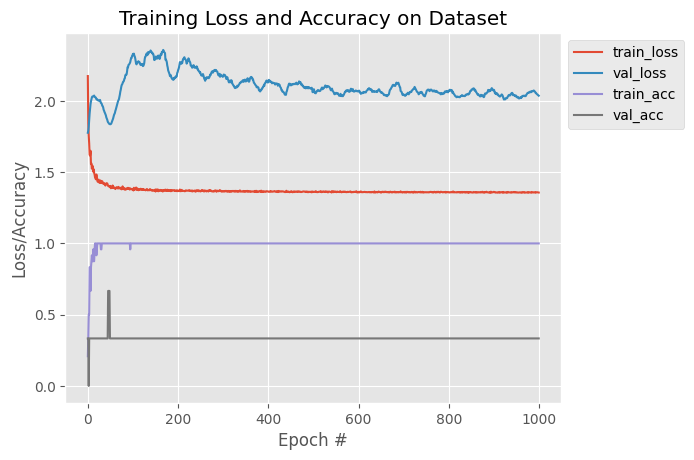

In [18]:
import torch
import torch.nn
from collections import OrderedDict
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_
from torch.nn import Sequential, Module, Conv1d, Linear, MaxPool1d, Dropout, Flatten, GELU, Sigmoid, LogSoftmax, CrossEntropyLoss, BatchNorm1d
from torch import flatten
from torch.optim import Adam, AdamW
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time


class LeNet(Module):


    def __init__(self, output=6):
        """
        A simple convolutional neural network, based on LeNet from (LeCun 1989)

        Args:
            shape (np-like): the architecture for the CNN.
            for
                (input, hidden, output) = shape
            where
                input - number of features.
                hidden - dimensions for hidden layer(s).
                output - number of classes.

        References:
        1. LeCun, Y. (1989). Generalization and network design strategies.
            Connectionism in perspective, 19(143-155), 18.
        2. LeCun, Y., Boser, B., Denker, J., Henderson, D., Howard,
            R., Hubbard, W., & Jackel, L. (1989).
            Handwritten digit recognition with a back-propagation network.
            Advances in neural information processing systems, 2.
        3. LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E.,
            Hubbard, W., & Jackel, L. D. (1989).
            Backpropagation applied to handwritten zip code recognition.
            Neural computation, 1(4), 541-551.
        4. Hendrycks, D., & Gimpel, K. (2016).
            Gaussian error linear units (gelus).
            arXiv preprint arXiv:1606.08415.
        5. Ioffe, S., & Szegedy, C. (2015, June).
            Batch normalization: Accelerating deep network training by reducing internal covariate shift.
            In International conference on machine learning (pp. 448-456). pmlr.
        6. Srivastava, N., Hinton, G., Krizhevsky, A.,
            Sutskever, I., & Salakhutdinov, R. (2014).
            Dropout: a simple way to prevent neural networks from overfitting.
            The journal of machine learning research, 15(1), 1929-1958.
        7. Hinton, G. E., Srivastava, N., Krizhevsky, A., Sutskever,
            I., & Salakhutdinov, R. R. (2012).
            Improving neural networks by preventing co-adaptation of feature detectors.
            arXiv preprint arXiv:1207.0580.
        8. Glorot, X., & Bengio, Y. (2010, March).
            Understanding the difficulty of training deep feedforward neural networks.
            In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).
            JMLR Workshop and Conference Proceedings.
        9. Loshchilov, I., & Hutter, F. (2017).
            Decoupled weight decay regularization.
            arXiv preprint arXiv:1711.05101.
        10. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016).
            Rethinking the inception architecture for computer vision.
            In Proceedings of the IEEE conference on computer vision
            and pattern recognition (pp. 2818-2826).
        """
        # CNN [1,2,3]
        super(LeNet, self).__init__()
        activation = GELU() # GELU [4]

        self.layers = Sequential(OrderedDict([
            # First convolutional layer
            ('conv1', Conv1d(in_channels=1, out_channels=64, kernel_size=5)),
            ('batchnorm1', BatchNorm1d(64)), # BatchNorm [5]
            ('activation1', activation),
            ('maxpool1', MaxPool1d(kernel_size=2, stride=2)),
            ('dropout1', Dropout(p=0.5)), # Dropout [6,7]
            # Second convolutional layer
            ('conv2', Conv1d(in_channels=64, out_channels=128, kernel_size=5)),
            ('batchnorm2', BatchNorm1d(128)),
            ('activation2', activation),
            ('maxpool2', MaxPool1d(kernel_size=2, stride=2)),
            ('dropout2', Dropout(p=0.5)),
            # Fully connected layer 1
            ('flatten', Flatten()),
            ('fc1', Linear(in_features=32256, out_features=800)),  # With 4 convolutional layers
            ('batchnorm3', BatchNorm1d(800)),
            ('activation3', activation),
            ('dropout3', Dropout(p=0.5)),
            # Fully connected layer 2
            ('fc2', Linear(in_features=800, out_features=output)),
            # Output layer.
            ('batchnorm4', BatchNorm1d(output)),
            ('activation4', LogSoftmax(dim=1)),
        ]))

    def forward(self, x):
        # Forward pass of the convolutional neural network.
        for layer in self.layers:
            x = layer(x)
        return x

print("[INFO] Initialize cuda environment")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPUs if available.

print("[INFO] Initializing the LeNet model")

model = LeNet()

 # Xavier initialization [8]
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
        xavier_uniform_(m.weight)

model.apply(init_weights)

if torch.cuda.is_available():
    model.to("cuda")

# AdamW [9]
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Label smoothing [10]
label_smoothing = 0.5
loss_function = CrossEntropyLoss(label_smoothing=label_smoothing)

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

print("[INFO] Training the network")
startTime = time.time()

# Training the CNN model.
for e in range(0, epochs):
    # Puts the model in train mode.
    model.train()

    total_train_loss = 0
    total_val_loss = 0

    train_correct = 0
    val_correct = 0

    # Training routine
    # Note: the benefit of using torch's DataLoader,
    # is that is automatically yields batches of training data.
    # This makes it ammeneable to training a deep neural network.
    for (x,y) in train_loader:
        (x,y) = (x.to(device), y.to(device))
        prediction = model(x.unsqueeze(1))
        loss = loss_function(prediction, y)
        optimizer.zero_grad()  # 1. Zero out the gradients
        loss.backward() # 2. Perform a backwards pass.
        optimizer.step() # 3. Update the weights.
        total_train_loss += loss
        train_correct += (prediction.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # Evalulation routine
    # no_grad() turns off gradient tracking and computation.
    with torch.no_grad():
        # Puts the model in evaluation mode.
        model.eval()
        for (x,y) in val_loader:
            (x,y) = (x.to(device), y.to(device))
            prediction = model(x.unsqueeze(1))
            total_val_loss = loss_function(prediction,y)
            val_correct += (prediction.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = total_train_loss / train_steps
    avgValLoss = total_val_loss / val_steps

    # calculate the training and validation accuracy
    trainCorrect = train_correct / len(train_loader.dataset)
    valCorrect = val_correct / len(val_loader.dataset)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # Print telemetry every 50 epochs, to avoid spamming standard out.
    if e % 50 == 0:
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

    # Early stopping
    # if valCorrect >= 1.00 and trainCorrect >= 1.00:
    #     print("[INFO] Finished on => EPOCH: {}/{}".format(e + 1, epochs))
    #     print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    #     print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))
    #     break;

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("model_accuracy.png")
# serialize the model to disk
# torch.save(model, "model.h5")

In [19]:
# switch off autograd
with torch.no_grad():
    # loop over the test set
    datasets = [("train", train_loader), ("validation", val_loader), ("test", test_loader)]
    for name, dataset in datasets:
        for (x,y) in dataset:
            (x,y) = (x.to(device), y.to(device))
            y_true = y
            pred = model(x.unsqueeze(1))
            y_pred = pred.argmax(axis=1).cpu().numpy()
            test_correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            print(f"[INFO] {name} accuracy {test_correct} / {len(x)}")

[INFO] train accuracy 24.0 / 24
[INFO] validation accuracy 1.0 / 3
[INFO] test accuracy 0.0 / 3
